In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
url = "https://api.bsmsa.eu/ext/api/bsm/chargepoints/v1/chargepoints"
df = pd.read_json(url)
df = pd.DataFrame(df["result"].values[0])
df.drop("Created", axis = 1, inplace = True)

Cleaning up the columns by removing dedundant data and forcing correct data types:

In [3]:
for name in ["Status", "ParkingLevel", "Place", "Vehicle"]:
    df[name] = pd.to_numeric(df[name], errors = "coerse")

for i in range(len(df.Menneke)):
    if isinstance(df.Menneke[i], bool) == False:
        df.Menneke[i] = False
        
for i in range(len(df.Schuko)):
    if isinstance(df.Schuko[i], np.bool_) == False:
        df.Schuko[i] = False
df.Updated = pd.to_datetime(df.Updated)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Translate tthe Vehicle and Status to text

In [4]:
status = {0: "Available", 1: "Occupied", 2: "Broken", 3: "Not available", 4: "Reserved", 5: "Charging"}
vehicle = {0: "car", 1: "motorcycle"}
df.Vehicle = df.Vehicle.map(vehicle)
df.Status = df.Status.map(status)

Check out the distribution of the charging station statuses, graphically: 

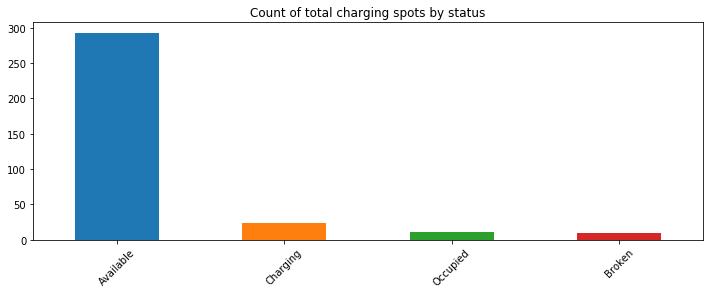

In [7]:
df["Status"].value_counts().plot(kind = 'bar', figsize = (12,4))
plt.title("Count of total charging spots by status")
plt.xticks(rotation = 45)
plt.show()

Create the new counts for availability

In [8]:
df["CountTotal"] = 1
df["CountAvailable"] = 0
for i in range(len(df.Status)):
    if df.Status[i] == "Available":
        df["CountAvailable"][i] = 1
df["DateUpdated"]  = [datetime.datetime.date(d) for d in df["Updated"]]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


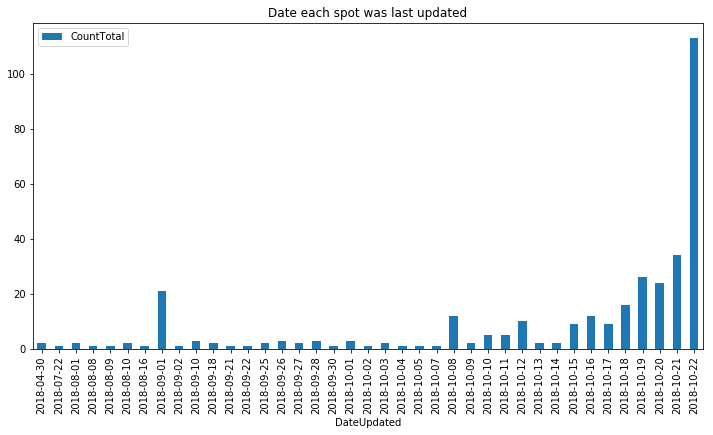

In [9]:
date_group = df[["CountTotal", "DateUpdated"]].groupby("DateUpdated").count()
date_group.reset_index(inplace=True)
date_group.plot(kind = 'bar', x = "DateUpdated", figsize=(12,6))
plt.title("Date each spot was last updated")
plt.show()

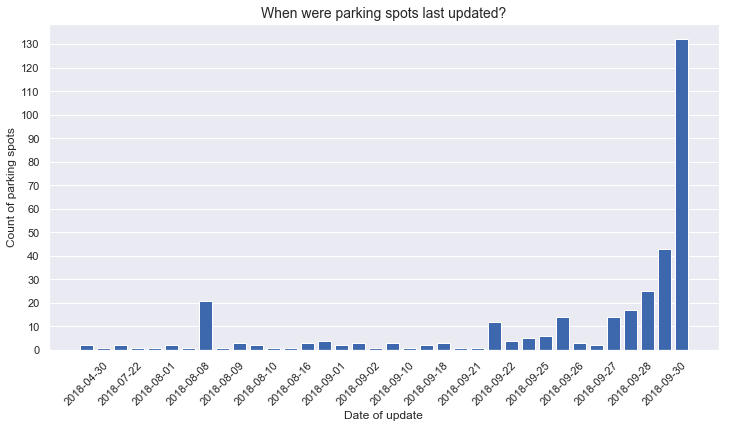

In [343]:
plt.figure(figsize = (12,6))
sns.barplot(x ="DateUpdated", y = "CountTotal", data = date_group, color="#2a64c1")
plt.title("When were parking spots last updated?", size=14)
plt.xlabel("Date of update")
plt.ylabel("Count of parking spots")
plt.xticks(rotation = 45)
plt.locator_params(nbins=20)
plt.show()

Pivoting on Status so we can get all the counts of spots per status in each parking station

In [10]:
pivot = df.pivot_table(values = "CountTotal", index = ["ChargeBoxID", "Vehicle", "Lat", "Lng", "ParkingName", "Address"], 
                       columns=["Status"], aggfunc="sum", 
                       margins = False).fillna(0)
pivot.reset_index(inplace = True)

Splitting the pivot into the car one and the motorcycle one so we can then merge them horizontally 

In [11]:
pivot_car = pivot[pivot.Vehicle == "car"]
pivot_moto = pivot[pivot.Vehicle == "motorcycle"]
pivot_car.drop("Vehicle", axis = 1, inplace = True)
pivot_moto.drop("Vehicle", axis = 1, inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
pivot_final = pivot_car.merge(pivot_moto, how = 'outer', 
                on = ['ChargeBoxID','Lat', 'Lng', 'ParkingName', 'Address'], 
                suffixes = ("_car", "_moto"))

Now we need to clean up our value counts for availability a little bit and calculate the total availability of cars and motos per charging stations. 

In [13]:
pivot_final.loc[:,["Lat", "Lng"]] = pivot_final[["Lat", "Lng"]].applymap(pd.to_numeric)
pivot_final["All_car"] = pivot_final["Available_car"] + pivot_final["Broken_car"] + pivot_final["Charging_car"] + pivot_final["Occupied_car"]
pivot_final["All_moto"] = pivot_final["Available_moto"] + pivot_final["Broken_moto"] + pivot_final["Charging_moto"] + pivot_final["Occupied_moto"]

And now we want to create the descriptions that will later be used as the pop-up info in our map.

In [14]:
pivot_final["Car_availability"] = "Available car spots:\t" + pivot_final["Available_car"].apply(lambda x: str(round(x)) if np.isnan(x) == False else x) + "/" + pivot_final["All_car"].apply(lambda x: str(round(x)) if np.isnan(x) == False else x)
pivot_final["Moto_availability"] = "Available motorcycle spots:\t" + pivot_final["Available_moto"].apply(lambda x: str(round(x)) if np.isnan(x) == False else x) + "/" + pivot_final["All_moto"].apply(lambda x: str(round(x)) if np.isnan(x) == False else x)
pivot_final["Total_available"] = pivot_final[["All_car", "All_moto"]].fillna(0).sum(axis = 1)
pivot_final["Description"] = pivot_final[["ParkingName", "Address", "Car_availability", "Moto_availability"]].fillna("").apply(
    lambda x: x.str.cat(sep='<br>'), axis=1)

Finally we'll need to assign the color for the markers as a column in our dataframe.

In [15]:
pivot_final["Color"] = pivot_final["Total_available"].apply(lambda x: "#fcd6bf" if x == 0 else "#3186cc")

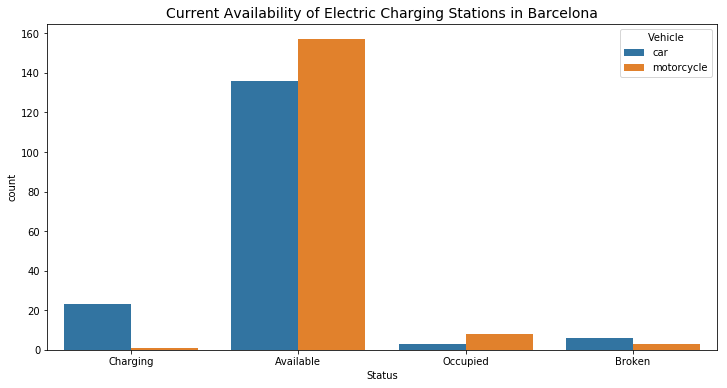

In [16]:
plt.figure(figsize = (12,6))
ax = sns.countplot(x = df["Status"], hue = df["Vehicle"], dodge = True)
plt.title("Current Availability of Electric Charging Stations in Barcelona", size = 14)
plt.show()

#for i in df["Status"]

In [17]:
# Additional : show numbers on top of each bar

In [18]:
import folium
from IPython.display import HTML, display

In [19]:
### We won't use this for now as it breaks everything :D

# html = pd.DataFrame(
#        pivot_final[["ParkingName", "Address", "Car_availability", "Moto_availability"]].iloc[i]).to_html(
#        index = False, justify = 'center', header = False, na_rep = "") 

In [26]:
mapo = folium.Map(location = [41.390205, 2.154007], 
                  zoom_start = 13, 
                  tiles = 'cartodbpositron')

for i in range(32):
    tooltip = pivot_final["Description"].iloc[i]
    size = pivot_final["Total_available"].iloc[i]*2
    folium.vector_layers.CircleMarker(
        location = [float(pivot_final.iloc[i]["Lat"]), float(pivot_final.iloc[i]["Lng"])],
        #popup = html,
        tooltip = tooltip,
        radius=size,
        color=pivot_final["Color"].iloc[i],
        fill=True,
        fill_color=pivot_final["Color"].iloc[i]
    ).add_to(mapo)

mapo.save("mapo.html")

display(mapo)